In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

torch.manual_seed(2)
torch.cuda.manual_seed_all(2)

In [2]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  return image

In [3]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(1,10,kernel_size=5,stride=1)
    self.conv2 = nn.Conv2d(10,10,kernel_size=5,stride=1)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2) #2x2 maxpool
    self.fc1 = nn.Linear(4*4*10,100)
    self.fc2 = nn.Linear(100,10)

  def forward(self,x):
    x = F.relu(self.conv1(x)) #24x24x10
    x = self.pool(x) #12x12x10
    x = F.relu(self.conv2(x)) #8x8x10
    x = self.pool(x) #4x4x10
    x = x.view(-1, 4*4*10) #flattening
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


In [4]:
train_ds = datasets.MNIST('./data',train=True,download=True, transform=transforms.Compose([transforms.ToTensor()]))
batch_size = 100
validation_split = .1
shuffle_dataset = True
random_seed= 2

# Creating data indices for training and validation splits:
dataset_size = len(train_ds)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',train=False,download=True,
      transform=transforms.Compose([transforms.ToTensor()])),batch_size=batch_size,shuffle=True)

# fig, ax = plt.subplots(nrows=2,ncols=3)

# i=0
# for row in ax:
#   for col in row:
#     col.imshow(im_convert(train_loader.dataset[i][0]))
#     col.set_title("digit "+str(train_loader.dataset[i][1]))
#     col.axis("off")
#     i+=1



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16149450.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 486864.14it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4411382.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11179887.77it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
model = Net().cuda()
optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(validation_loader)*batch_size

for i in range(10):
  total_loss = 0
  total_acc = 0
  c = 0
  for images,labels in train_loader:
    images = images.cuda()
    labels = labels.cuda()

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1
  # Validation
  total_loss_val = 0
  total_acc_val = 0
  c = 0
  for images,labels in validation_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images)
    loss = criterion(output,labels)

    total_loss_val +=loss.item()
    total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1

  train_errors.append(total_loss/n_train)
  train_acc.append(total_acc/n_train)
  val_errors.append(total_loss_val/n_val)
  val_acc.append(total_acc_val/n_val)

print("Trainig Complete.")

Trainig Complete.


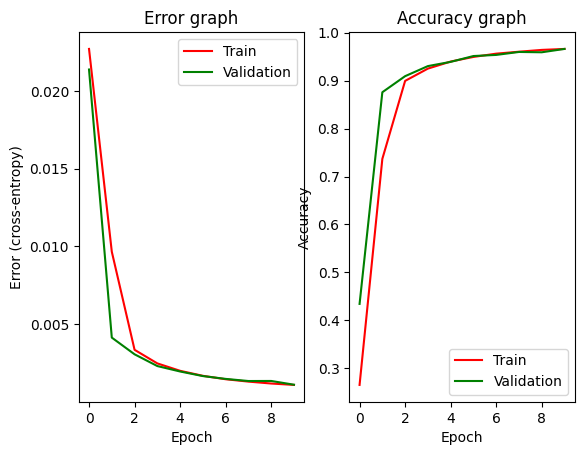

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error graph")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy graph")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

In [7]:
total_acc = 0
for images,labels in test_loader:
  images = images.cuda()
  labels = labels.cuda()
  output = model(images)
  total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0

print("Test accuracy :",total_acc/len(test_loader.dataset))

Test accuracy : 0.9728
